# ResNet-18 Classification for Aerial Landscape Dataset
COMP9517 Group Project - Deep Learning Method

In [16]:

# Imports
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torchvision.datasets import ImageFolder
from torch import nn, optim
from tqdm import tqdm
import seaborn as sns


In [17]:
import os
print(os.listdir("Aerial_Landscapes"))


['.DS_Store', 'Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [18]:

# Config
data_dir = 'Aerial_Landscapes'  # Update if running locally
batch_size = 32
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os

print(os.listdir(data_dir))



['.DS_Store', 'Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [19]:
import os

# 遍历根目录，删除 .DS_Store 文件
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file == '.DS_Store':
            os.remove(os.path.join(root, file))
            print(f"Removed: {os.path.join(root, file)}")


Removed: Aerial_Landscapes/.DS_Store


In [20]:

# Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [21]:

# Load Dataset
dataset = ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [22]:

# Load Pretrained ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
  0%|          | 128k/44.7M [00:00<01:09, 668kB/s]

100%|██████████| 44.7M/44.7M [02:57<00:00, 263kB/s]


In [23]:

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader.dataset):.4f}")


100%|██████████| 300/300 [00:24<00:00, 12.39it/s]


Epoch 1/5, Loss: 0.3955


100%|██████████| 300/300 [00:23<00:00, 12.52it/s]


Epoch 2/5, Loss: 0.0866


100%|██████████| 300/300 [00:22<00:00, 13.53it/s]


Epoch 3/5, Loss: 0.0505


100%|██████████| 300/300 [00:22<00:00, 13.54it/s]


Epoch 4/5, Loss: 0.0385


100%|██████████| 300/300 [00:22<00:00, 13.51it/s]

Epoch 5/5, Loss: 0.0271


In [24]:

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

 Agriculture       0.99      0.98      0.99       154
     Airport       0.99      0.97      0.98       184
       Beach       0.97      0.99      0.98       149
        City       0.99      0.96      0.97       157
      Desert       0.97      0.98      0.98       147
      Forest       0.99      0.98      0.98       170
   Grassland       0.95      0.98      0.97       159
     Highway       0.97      1.00      0.98       146
        Lake       0.90      0.99      0.94       164
    Mountain       0.98      0.95      0.97       165
     Parking       0.98      1.00      0.99       156
        Port       1.00      0.94      0.97       160
     Railway       0.96      0.98      0.97       163
 Residential       1.00      0.99      1.00       163
       River       0.97      0.93      0.95       163

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97   

<Figure size 1000x1000 with 0 Axes>

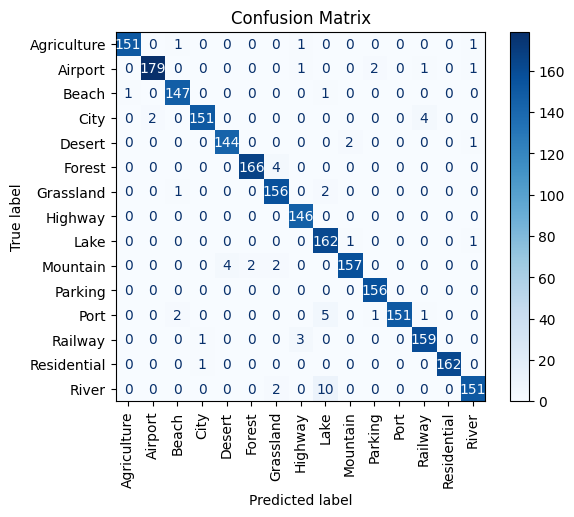

In [25]:

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
